# 泰坦尼克号乘客生存预测

## 1.数据总览
Titanic 生存模型预测，其中包含两组数据：titanic_train.csv 和 titanic_test.csv，分别为训练集和测试集。

In [1]:
!ls ./data

titanic_test.csv  titanic_train.csv


In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

读取数据并观察数据的前几行

In [3]:
train_data = pd.read_csv('data/titanic_train.csv')
test_data = pd.read_csv('data/titanic_test.csv')

sns.set_style('whitegrid')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()
print('-' * 40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

 从以上信息可以看出，训练集 train_data 中的特征 Age、Cabin 和 Embarked 存在缺失值。其中特征 Age 缺失 177 个值，特征 Cabin 缺失 687 个值，特征 Embarked 缺失 2 个值。测试集 train_data 中特征 Age、Cabin 和 Fare 存在缺失值。其中特征 Age 缺失 86 个值，特征 Fare 缺失 1 个值，特征 Cabin 缺失 327 个值。

绘制存活的比例图：

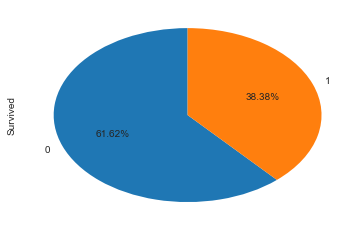

In [5]:
train_data['Survived'].value_counts().plot.pie(labeldistance = 1.1,
                                               autopct = '%1.2f%%',
                                               shadow = False,
                                               startangle = 90,
                                               pctdistance = 0.6)

# labeldistance: 文本的位置距离原点有多远，1.1指1.1倍半径的位置
# autopct: 圆中文本格式，%3.1f%%表示小数有三位，整数有一位的浮点数
# shadow: 饼图是否有阴影
# startangle: 起始角度，0表示从0开始逆时针转，为第一块。一般选择从90度开始比较好看
# pctdistance: 百分比的text离圆心的距离
# patches，l_texts，p_texts，为了得到饼图的返回值，p_texts:饼图内部文本，l_texts:饼图外的label的文本


## 2. 缺失值处理方法
在对数据进行分析时发现存在缺失值。对于缺失值，一般有以下几种处理方法：

1. 如果数据集很多，只有很少的缺失值，可以删掉带有缺失值的行。
2. 如果该特征对于训练模型来说不是很重要，则可以对缺失值赋均值或者众数。
3. 对于标称特征，可以赋一个代表缺失的值，比如’U0‘。因为缺失本身也可能代表着一些隐含信息。比如船舱号 Cabin 这一特征，缺失可能代表没有船舱。

比如在哪儿上船 Embarked 这一特征（共三个上船地点），缺失 2 个值，可以用众数赋值。

In [6]:
train_data.Embarked[train_data.Embarked.isnull()] = train_data.Embarked.dropna().mode().values
# replace missing value with U0
train_data['Cabin'] = train_data.Cabin.fillna('U0')
# train_data.Cabin[train_data.Cabin.isnull()] = 'U0'

4. 使用回归、随机森林等模型来预测缺失特征的值。

因为 Age 在本数据集中是一个非常重要的特征，所以保证一定的缺失值填充准确率是十分重要的，对结果也会产生较大影响。一般情况下，会使用数据完整的条目作为模型的训练集，以此来预测缺失值。对于当前数据，可以使用随机森林来预测，也可以使用线性回归预测。这里使用随机森林预测模型，选取数据集中的数值属性作为特征（因为 sklearn 的模型只能处理数值属性，所以只选择数值属性。但在实际应用中，需要将非数值属性转换为数值属性。

In [7]:
from sklearn.ensemble import RandomForestRegressor

# choose training data to predict age
age_df = train_data[['Age','Survived','Fare','Parch','SibSp','Pclass']]
age_df_notnull = age_df.loc[(train_data['Age'].notnull())]
age_df_isnull = age_df.loc[(train_data['Age'].isnull())]
X = age_df_notnull.values[:,1:]
Y = age_df_notnull.values[:,0]

# use RandomForestRegression to train data
RFR = RandomForestRegressor(n_estimators = 1000, n_jobs = -1)
RFR.fit(X,Y)
predictAges = RFR.predict(age_df_isnull.values[:,1:])
train_data.loc[train_data['Age'].isnull(), ['Age']] = predictAges

缺失数据处理后的 DataFrame：

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 3. 分析数据关系

### 3.1 性别与是否生存的关系（Sex）

In [9]:
print(train_data.groupby(['Sex', 'Survived'])['Survived'].count())

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64


In [10]:
train_data[['Sex','Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


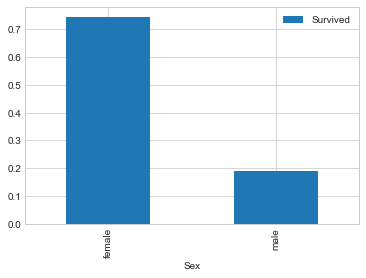

In [11]:
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

以上结果显示，女性生存者占女性总数的74.2%，男性生存者占男性总数的18.89%。由此可见，女性在本次灾难发生时的生还几率远远大于男性。

### 3.2 船舱等级和生存与否的关系（Pclass）

In [12]:
print(train_data.groupby(['Pclass','Survived'])['Pclass'].count())

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Pclass, dtype: int64


In [13]:
print(train_data[['Pclass','Survived']].groupby(['Pclass']).mean())

        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363


由以上数据可以很明显地看出，船舱等级1、2、3的乘客生存率分别为0.63、0.47和0.24。船舱等级越高的乘客，存活几率越大。

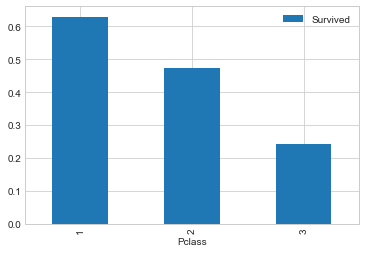

In [14]:
train_data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()

#### 不同等级船舱的男女生存率

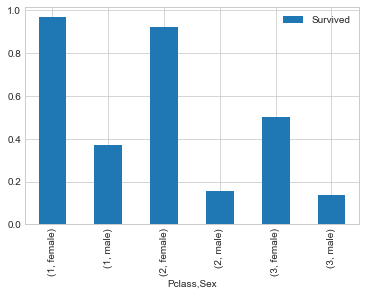

In [15]:
train_data[['Sex','Pclass','Survived']].groupby(['Pclass','Sex']).mean().plot.bar()

从上图可以看出，不论男女，高等级客舱的存活率都更大。同时不同客舱等级中，女性的存活率都大于男性。

### 3.3 年龄与存活与否的关系（Age）

下面将分别分析不同性别、不同船舱等级下年龄分布与生存状况的关系。

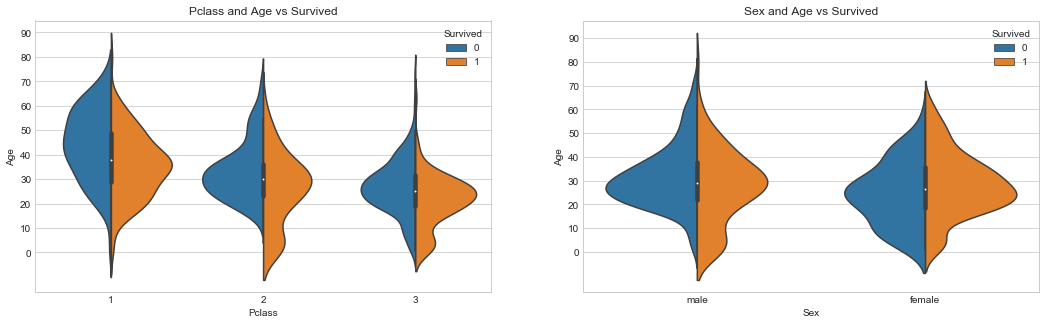

In [16]:
fig, ax = plt.subplots(1,2, figsize=(18,5))
ax[0].set_yticks(range(0,110,10))
sns.violinplot('Pclass','Age',hue='Survived',data=train_data,split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')

ax[1].set_yticks(range(0,100,10))
sns.violinplot('Sex','Age',hue='Survived',data=train_data,split=True,ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')

plt.show()

#### 分析总体年龄分布

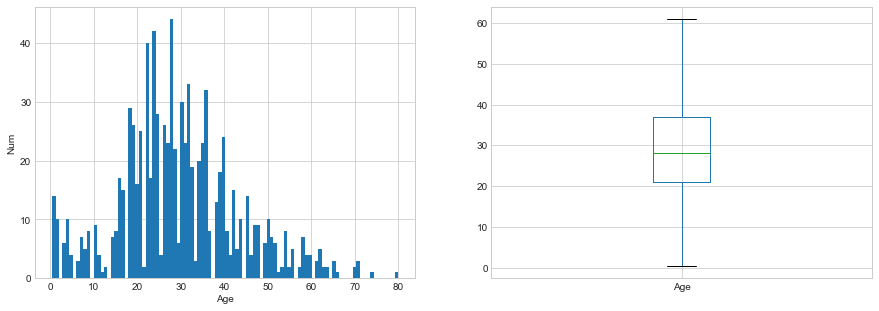

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(121)
train_data['Age'].hist(bins=100)
plt.xlabel('Age')
plt.ylabel('Num')

plt.subplot(122)
train_data.boxplot(column='Age',showfliers=False)
plt.show()

#### 不同年龄下生存与否的分布情况

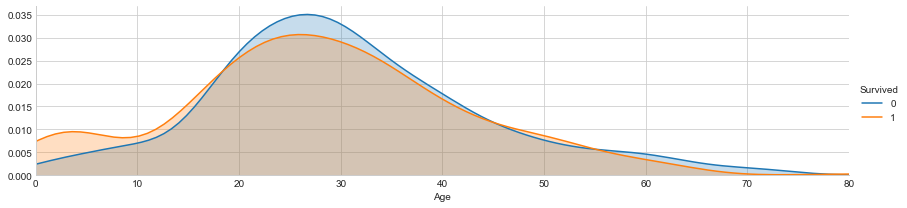

In [18]:
facet = sns.FacetGrid(train_data, hue='Survived',aspect=4)
facet.map(sns.kdeplot,'Age',shade=True)
facet.set(xlim=(0,train_data['Age'].max()))
facet.add_legend()

#### 不同年龄下的生存率

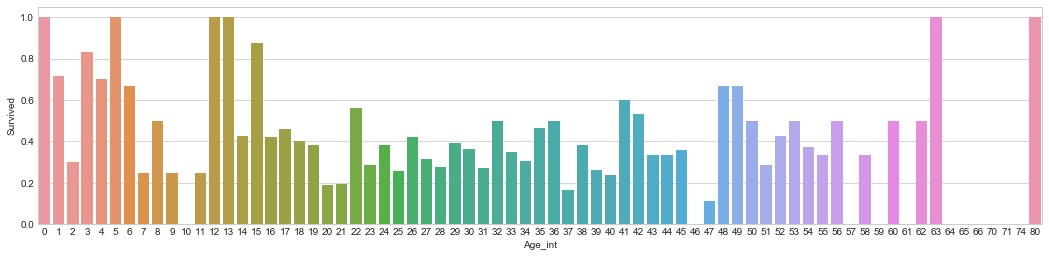

In [19]:
# average survived passengers by age
fig,axis1 = plt.subplots(1,1,figsize=(18,4))
train_data['Age_int'] = train_data['Age'].astype(int)
# astype(): 将pandas对象转换为指定类型
average_age = train_data[['Age_int','Survived']].groupby(['Age_int'],as_index=False).mean()
# as_index = Fasle, 将数据输出格式设置为SQL风格
sns.barplot(x='Age_int',y='Survived',data=average_age)

In [20]:
print(train_data['Age'].describe())

count    891.000000
mean      29.654714
std       13.734529
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64


训练集中有杨蓓891个，平均年龄约29.67，标准差13.74，最小年龄0.43，最大年龄80。按照年龄将乘客分为儿童、少年、成年和老年。分析这四个群体的生还情况。

In [21]:
bins = [0, 12, 18, 65, 100]
train_data['Age_group'] = pd.cut(train_data['Age'],bins)
by_age = train_data.groupby('Age_group')['Survived'].mean()
print(by_age)

Age_group
(0, 12]      0.506173
(12, 18]     0.466667
(18, 65]     0.364512
(65, 100]    0.125000
Name: Survived, dtype: float64


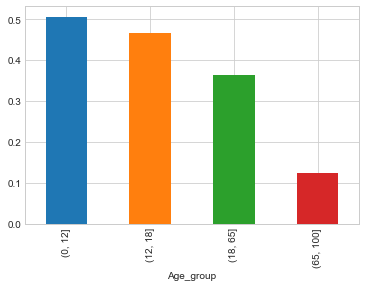

In [22]:
by_age.plot(kind='bar')

### 3.4 称呼与存活与否的关系（Name）

通过观察可以看出乘客中有很多称呼，如：Mr、Miss、Mrs等。从称呼中我们可以看出一个人的性别、年龄，同时也可以看出一个人的社会地位，如：Dr、Lady、Major（少校）、Master（硕士、主任、师傅）等。

In [23]:
train_data['Title'] = train_data['Name'].str.extract('([A-Za-z]+)\.',expand=False)
pd.crosstab(train_data['Title'],train_data['Sex'])
# 交叉表（crosstab）是统计分组频率的特殊透视表。

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


#### 不同称呼与生存率的关系

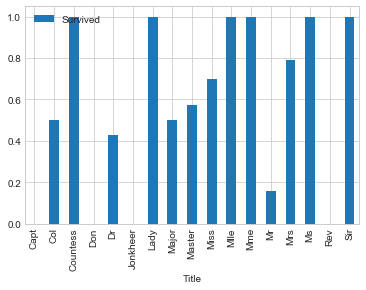

In [24]:
train_data[['Title','Survived']].groupby(['Title']).mean().plot.bar()

#### 观察名字长度与生存率之间是否存在关系

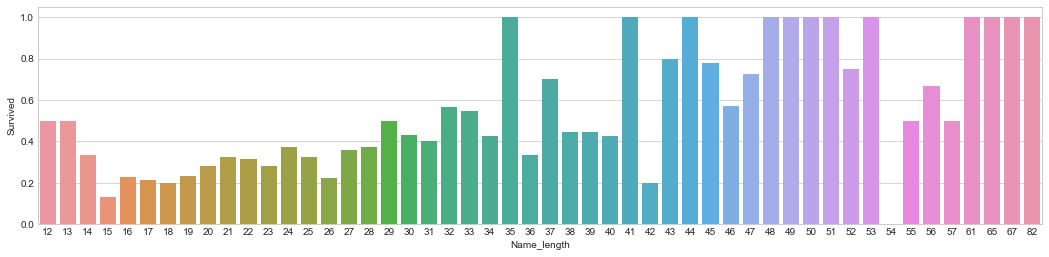

In [25]:
fig,axis1 = plt.subplots(1,1,figsize=(18,4))
train_data['Name_length'] = train_data['Name'].apply(len)
name_length = train_data[['Name_length','Survived']].groupby(['Name_length'], as_index=False).mean()
sns.barplot(x='Name_length',y='Survived',data=name_length)

从以上图片我们可以看出，名字长度对于一个人存活与否也存在一定的相关性。

### 有无兄弟姐妹和存活与否的关系（SibSp）

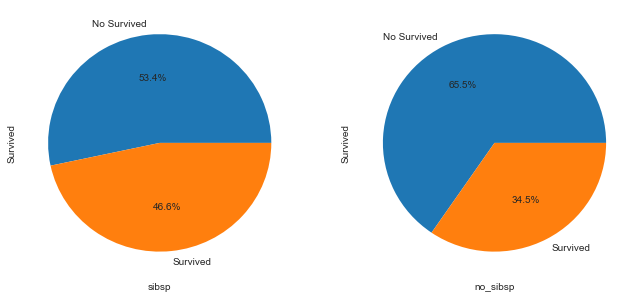

In [26]:
# 首先将数据分为有兄弟姐妹和没有兄弟姐妹两组
sibsp_df = train_data[train_data['SibSp'] != 0]
no_sibsp_df = train_data[train_data['SibSp'] == 0]

plt.figure(figsize=(11,5))
plt.subplot(121)
sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct='%1.1f%%')
plt.xlabel('sibsp')

plt.subplot(122)
no_sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'],autopct='%1.1f%%')
plt.xlabel('no_sibsp')

plt.show()

从上图可以明显看出，有兄弟姐妹的人的存活率为46.6%，明显高出没有兄弟姐妹的人的存活率34.5%。

### 3.6 有无父母子女与存活与否的关系（Parch）

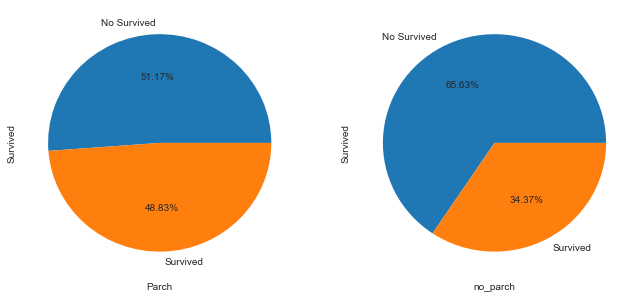

In [27]:
parch_df = train_data[train_data['Parch'] != 0]
no_parch_df = train_data[train_data['Parch'] == 0]

plt.figure(figsize=(11,5))
plt.subplot(121)
parch_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'], autopct='%1.2f%%')
plt.xlabel('Parch')

plt.subplot(122)
no_parch_df['Survived'].value_counts().plot.pie(labels=['No Survived','Survived'], autopct='%1.2f%%')
plt.xlabel('no_parch')

plt.show()

从上图看出，有父母子女的人的存活率为48.84%，高于没有父母子女的人的存活率34.37%。可以认为，有无父母子女与存活与否有很大关系。

### 3.7 亲友人数与存货与否的关系（SibSp & Parch）

Text(0.5,1,'SibSp and Survived')

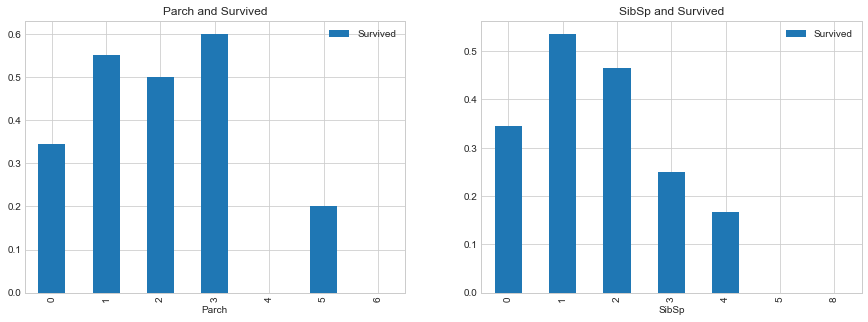

In [28]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
train_data[['Parch','Survived']].groupby(['Parch']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Parch and Survived')
train_data[['SibSp','Survived']].groupby(['SibSp']).mean().plot.bar(ax=ax[1])
ax[1].set_title('SibSp and Survived')

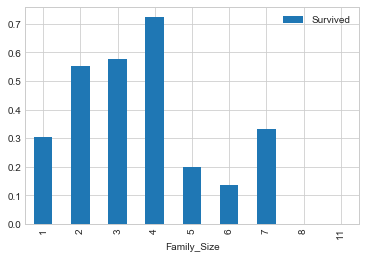

In [29]:
train_data['Family_Size'] = train_data['Parch'] + train_data['SibSp'] + 1
train_data[['Family_Size','Survived']].groupby(['Family_Size']).mean().plot.bar()

从以上图表可以看出，若独自一人，存活率较低。但是如果家人亲友过多，存活率也很低。

### 3.8 票价分布与存或与否的关系（Fare）

#### 票价分布情况

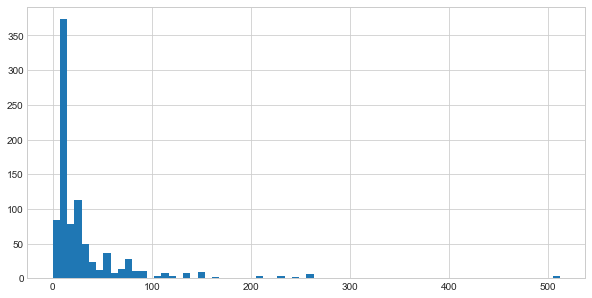

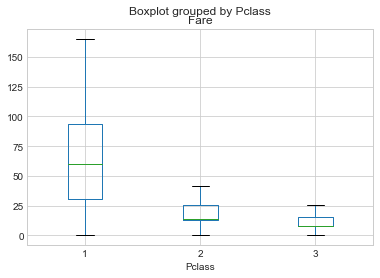

In [30]:
plt.figure(figsize=(10,5))
train_data['Fare'].hist(bins=70)

train_data.boxplot(column='Fare', by='Pclass',showfliers=False)
plt.show()

In [31]:
print(train_data['Fare'].describe())

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


#### 生存与否与票价均值和方差的关系

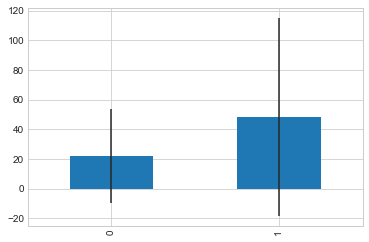

In [32]:
fare_not_survived = train_data['Fare'][train_data['Survived'] == 0]
fare_survived = train_data['Fare'][train_data['Survived'] == 1]

average_fare = pd.DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = pd.DataFrame([fare_not_survived.std(), fare_survived.std()])
average_fare.plot(yerr=std_fare,kind='bar',legend=False)

plt.show()

由上图可以看出，票价与是否生还有一定相关性，生还者的平均票价要大于遇难者的平均票价。

### 3.9 船舱类型和存活与否的关系（Cabin）

船舱缺失值过多，有效值仅204个，很难分析出船舱与存活的关系。这里可以进行一些简单的分析，把缺失的数据分为一类。简单地将数据分为是否有Cabin记录作为特征，与生存与否进行分析。

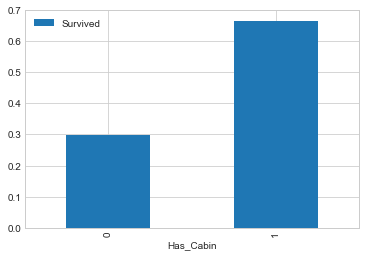

In [33]:
# Replace missing values with "U0"
train_data.loc[train_data.Cabin.isnull(),'Cabin'] = 'U0'
train_data['Has_Cabin'] = train_data['Cabin'].apply(lambda x: 0 if x == 'U0' else 1)
train_data[['Has_Cabin','Survived']].groupby(['Has_Cabin']).mean().plot.bar()

由上图可以看出，有Cabin记录的乘客的存活率明显大于没有Cabin记录的乘客。

#### 对不同类型的船舱进行分析

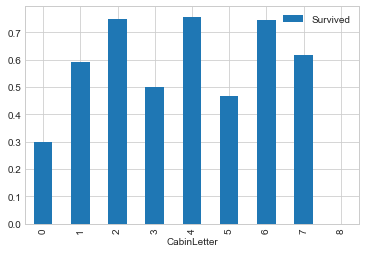

In [34]:
train_data['CabinLetter'] = train_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]
train_data[['CabinLetter','Survived']].groupby(['CabinLetter']).mean().plot.bar()

有上图可以看出，不同船舱生存率有差别，但是差别不是很大。所以在数据处理过程中，我们可以将这个特征剔除。

### 3.10 港口和存活与否的关系（Embarked）

泰坦尼克号从英国的南安普敦港出发，途径法国瑟堡和爱尔兰昆士敦，那么在昆士敦之前上船的人，有可能在瑟堡或昆士敦下船，这些人将不会遇到海难。

Text(0.5,1,'Embarked and Survived')

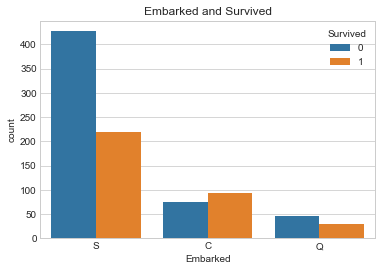

In [35]:
sns.countplot('Embarked', hue='Survived', data=train_data)
plt.title('Embarked and Survived')

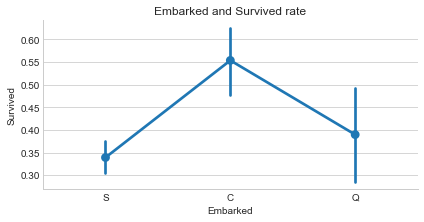

In [36]:
sns.factorplot('Embarked','Survived',data=train_data,size=3,aspect=2)
plt.title('Embarked and Survived rate')
plt.show()

由上图可以看出，在不同港口上船，存活率也不同，其中C最高，Q次之，S最低。

## 4. 变量转换

变量转换的目的是将数据转换为适用于模型使用的数据，不同模型接受不同类型的数据，Scikit-learn要求数据都是数字型numeric，所以我们要将一些非数字型的原始数据转换为数字型numeric。下面将对数据的转换进行介绍，以在进行特征工程的时候使用。

所有的数据可以分为两类：
1. 定性（Qualitative）变量可以以某种方式，Age就是一个很好的例子。
2. 定量（Quantitative）变量描述了物体的某一（不能被数学表示）方面，如Embarked。

### 定性（Qualitative）转换

### 4.1 Dummy Variables

类别变量或者二元变量。当 qualitative variable 是一些频繁出现的几个独立变量时，Dummy Variables 比较适用。Embarked 只包含’S‘，‘C’，‘Q’，我们可以使用下面的代码将其转换为 dummies。

In [37]:
embark_dummies = pd.get_dummies(train_data['Embarked'])
train_data = train_data.join(embark_dummies)
train_data.drop(['Embarked'],axis=1,inplace=True)

embarked_dummies = train_data[['S','C','Q']]
embarked_dummies.head()

,S,C,Q
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


### 4.2 Factoring

dummy 不好处理 Cabin 这种标称属性，因为变量较多。Pandas 有一个方法叫 factorize()，它可以创建一些数字，来表示类别变量，对每一个类别映射一个 ID，这种映射最后只生成一个特征，不像 dummy 会生成多个特征。

In [38]:
# Replace missing values with 'U0'
train_data['Cabin'][train_data.Cabin.isnull()] = 'U0'
train_data['CabinLetter'] = train_data['Cabin'].map(lambda x: re.compile('([a-zA-Z]+)').search(x).group())
train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]

train_data[['Cabin','CabinLetter']].head()

,Cabin,CabinLetter
0,U0,0
1,C85,1
2,U0,0
3,C123,1
4,U0,0


### 定量（Quantitative）转化

### 4.3 Scaling

Scaling 可以将一个很大范围的数值映射到一个很小范围（通常是 -1到1，或者是0到1），很多情况下我们需要将数值做 Scaling 使其范围大小一样，否则大范围数特征将会有更高的权重。比如：Age 的范围可能只是 0-100，而income 的范围可能是 0-10000000，在某些对数组大小敏感的模型中会影响其结果。

#### 对 Age 进行 Scaling

In [39]:
from sklearn import preprocessing

assert np.size(train_data['Age']) == 891
scaler = preprocessing.StandardScaler()
train_data['Age_scaled'] = scaler.fit_transform(train_data['Age'].values.reshape(-1,1))

print(train_data['Age_scaled'].head())

0   -0.557647
1    0.607955
2   -0.266246
3    0.389405
4    0.389405
Name: Age_scaled, dtype: float64


### 4.4 Binning

Binning 通过观察“邻居”（周围的值）将连续数据离散化。存储的值被分到一些“桶”或“箱”中，就像直方图的 bin 将数据划分成几块一样。

In [40]:
# Divide all fares into quartiles
train_data['Fare_bin'] = pd.qcut(train_data['Fare'],5)
print(train_data['Fare_bin'].head())

0      (-0.001, 7.854]
1    (39.688, 512.329]
2        (7.854, 10.5]
3    (39.688, 512.329]
4        (7.854, 10.5]
Name: Fare_bin, dtype: category
Categories (5, interval[float64]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] < (21.679, 39.688] < (39.688, 512.329]]


将数据Binning化之后，要么将数据factorize化，要么dummies化。

In [41]:
# qcut() create a new variable that idetifies the quartile range, but we can't use the string
# so either factorize or create dummies from the result

# factorize
train_data['Fare_bin_id'] = pd.factorize(train_data['Fare_bin'])[0]

# dummies
fare_bin_dummies_df = pd.get_dummies(train_data['Fare_bin']).rename(columns=lambda x: 'Fare_' + str(x))
train_data = pd.concat([train_data, fare_bin_dummies_df], axis=1)

## 5. 特征工程

在进行特征工程的时候，不仅需要对训练数据进行处理，还需要同时对测试数据进行处理，使得二者具有相同的数据类型和分布。

In [42]:
train_df_org = pd.read_csv('data/titanic_train.csv')
test_df_org = pd.read_csv('data/titanic_test.csv')
test_df_org['Survived'] = 0
combined_train_test = train_df_org.append(test_df_org)
# 891+418=1309 rows, 12 columns
PassergerId = test_df_org['PassengerId']

对数据进行特征工程，就是从各项参数中提取对输出结果有影响的特征，并将其作为训练模型的依据。一般来说，会先从含有缺失值的特征开始。

### 5.1 Embarked

以众数来填充 Embarked 项的缺失值。

In [43]:
combined_train_test['Embarked'].fillna(combined_train_test['Embarked'].mode().iloc[0],inplace=True)
# iloc[]: 根据行号返回数据，iloc[0]: 返回第一行的数据

对于三种不同的港口，由之前介绍的数值转换，我们有两种特征处理方式：dummy 和 factorizing。因为只有三个港口，我们可以直接用 dummy 处理。

In [44]:
combined_train_test['Embarked'] = pd.factorize(combined_train_test['Embarked'])[0]

# 使用pd.get_dummies获取one-hot编码
emb_dummies_df = pd.get_dummies(combined_train_test['Embarked'],prefix=combined_train_test[['Embarked']].columns[0])
# prefix: 加前缀
combined_train_test = pd.concat([combined_train_test, emb_dummies_df],axis=1)
# pd.concat(): 将两个dataframe合并，axis=1说明是行对齐。

### 5.2 Sex

对 Sex 同样进行 one-hot 编码。

In [45]:
# 首先将Sex特征进行factorizing
combined_train_test['Sex'] = pd.factorize(combined_train_test['Sex'])[0]

sex_dummies_df = pd.get_dummies(combined_train_test['Sex'],prefix=combined_train_test[['Sex']].columns[0])
combined_train_test = pd.concat([combined_train_test, sex_dummies_df], axis=1)

### 5.3 Name

首先从名字中提取各种称呼

In [46]:
combined_train_test['Title'] = combined_train_test['Name'].map(lambda x: re.compile(",(.*?)\.").findall(x)[0])
# findall(): 遍历整个字符串
combined_train_test['Title'] = combined_train_test['Title'].apply(lambda x:x.strip())
# strip(): 移出字符串首尾指定字符，此处移出首尾的空格

将各种称呼进行统一化处理

In [47]:
title_Dict = {}
# dict.update(): 对字典进行更新，把指定内容更新到dict中。
title_Dict.update(dict.fromkeys(['Capt','Col','Major','Dr','Rev'],'Officer'))
title_Dict.update(dict.fromkeys(['Don','Sir','the Countess','Dona','Lady'],'Royalty'))
title_Dict.update(dict.fromkeys(['Mme','Ms','Mrs'],'Mrs'))
title_Dict.update(dict.fromkeys(['Male','Miss'],'Miss'))
title_Dict.update(dict.fromkeys(['Mr'],'Mr'))
title_Dict.update(dict.fromkeys(['Master','Jonkheer'],'Master'))
# dict.fromkeys(sep[,value]): 创建一个字典，序列seq作为键，value作为这些键对应的初始值。 

combined_train_test['Title'] = combined_train_test['Title'].map(title_Dict)

使用 dummy 对不同的称呼进行分列

In [48]:
# 对Title进行factorizing
combined_train_test['Title'] = pd.factorize(combined_train_test['Title'])[0]
title_dummies_df = pd.get_dummies(combined_train_test['Title'],prefix=combined_train_test[['Title']].columns[0])
combined_train_test = pd.concat([combined_train_test, title_dummies_df],axis=1)

增加名字长度的特征

In [49]:
combined_train_test['Name_length'] = combined_train_test['Name'].apply(len)

### 5.4 Fare

由之前的分析可以知道，特征Fare缺失一个值，所以需要对该值进行填充。我们按照一二三等舱各自的均价来填充。

下面的transform将函数np.mean应用到各个group中。

In [50]:
combined_train_test['Fare'] = combined_train_test[['Fare']].fillna(combined_train_test.groupby('Pclass').transform(np.mean))

通过对Ticket数据的分析，我们可以看到部分票号数据有重复，同时结合亲属人数及名字的数据，和票价船舱等级对比，我们可以知道购买的票中有家庭票和团体票，所以我们需要将团体票的票价分配到每个人的头上。

In [51]:
combined_train_test['Group_Ticket'] = combined_train_test['Fare'].groupby(by=combined_train_test['Ticket']).transform('count')
# 将票价Fare用船票序号Ticket分组，并进行计数count，得到一张团体票对应多少人。
combined_train_test['Fare'] = combined_train_test['Fare'] / combined_train_test['Group_Ticket']
combined_train_test.drop(['Group_Ticket'], axis=1, inplace=True)
# 剔除无用特征'Group_Ticket'

使用binning给票价分等级

In [52]:
combined_train_test['Fare_bin'] = pd.qcut(combined_train_test['Fare'], 5)

对于5个等级的票价，可以继续使用dummy为票价等级分列。

In [53]:
combined_train_test['Fare_bin_id'] = pd.factorize(combined_train_test['Fare_bin'])[0]

fare_bin_dummies_df = pd.get_dummies(combined_train_test['Fare_bin_id']).rename(columns=lambda x: 'Fare_' + str(x))
combined_train_test = pd.concat([combined_train_test, fare_bin_dummies_df], axis=1)
combined_train_test.drop(['Fare_bin'], axis=1, inplace=True)

### 5.5 Pclass

下面将Pclass转换为dummy形式。同时为了更好地分析问题，假设对于不同等级的船舱，各船舱内部的票价也说明了各等级船舱的位置，这就有可能与逃生的顺序有关系。所以这里分出各个等级船舱里的高价位和低价位。

In [54]:
from sklearn.preprocessing import LabelEncoder

# 建立PClass Fare Category
def pclass_fare_category(df, pclass1_mean_fare, pclass2_mean_fare, pclass3_mean_fare):
    if df['Pclass'] == 1:
        if df['Fare'] <= pclass1_mean_fare:
            return 'Pclass1_Low'
        else:
            return 'Pclass1_High'
    elif df['Pclass'] == 2:
        if df['Fare'] <= pclass2_mean_fare:
            return 'Pclass2_Low'
        else:
            return 'Pclass2_High'
    elif df['Pclass'] == 3:
        if df['Fare'] <= pclass3_mean_fare:
            return 'Pclass3_Low'
        else:
            return 'Pclass3_High'

Pclass1_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([1]).values[0]
Pclass2_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([2]).values[0]
Pclass3_mean_fare = combined_train_test['Fare'].groupby(by=combined_train_test['Pclass']).mean().get([3]).values[0]

# 建立Pclass_Fare Category
combined_train_test['Pclass_Fare_Category'] = combined_train_test.apply(pclass_fare_category, args=(
    Pclass1_mean_fare, Pclass2_mean_fare, Pclass3_mean_fare), axis=1)
pclass_level = LabelEncoder()

# 给每一项添加标签
pclass_level.fit(np.array(
    ['Pclass1_Low', 'Pclass1_High', 'Pclass2_Low', 'Pclass2_High', 'Pclass3_Low', 'Pclass3_High']))

# 转换成数值
combined_train_test['Pclass_Fare_Category'] = pclass_level.transform(combined_train_test['Pclass_Fare_Category'])

# dummy 转换
pclass_dummies_df = pd.get_dummies(combined_train_test['Pclass_Fare_Category']).rename(columns=lambda x: 'Pclass_' + str(x))
combined_train_test = pd.concat([combined_train_test, pclass_dummies_df], axis=1)

将Pclass特征factorize化

In [55]:
combined_train_test['Pclass'] = pd.factorize(combined_train_test['Pclass'])[0]

### 5.6 Parch and SibSp

由之前的分析可以知道，没有亲友或者有太多亲友会影响一个人的是否存活Survived。所以将二者合并为一项FamilySize，同时也保留这两项。

In [56]:
def family_size_category(family_size):
    if family_size <= 1:
        return 'Single'
    elif family_size <= 4:
        return 'Small_Family'
    else:
        return 'Large_Family'
    
combined_train_test['Family_Size'] = combined_train_test['Parch'] + combined_train_test['SibSp'] + 1
combined_train_test['Family_Size_Category'] = combined_train_test['Family_Size'].map(family_size_category)

le_family = LabelEncoder()
le_family.fit(np.array(['Single','Small_Family','Large_Family']))
combined_train_test['Family_Size_Category'] = le_family.transform(combined_train_test['Family_Size_Category'])
# le_family(LabelEncoder): 将标签标准化（转化成数值）。

family_size_dummies_df = pd.get_dummies(combined_train_test['Family_Size_Category'], prefix=combined_train_test[['Family_Size_Category']].columns[0])
# prefix: string, 追加DataFrame列名的字符串，即给列命名。
combined_train_test = pd.concat([combined_train_test, family_size_dummies_df], axis=1)

### 3.7 Age

Age项缺失值较多，所以不可以直接填充age的众数或者平均数。

常见的有两种对年龄的填充方式：一种是根据Title中的称呼，如Mr，Master、Miss等称呼不同类别的人的平均年龄来填充；一种是综合几项如Sex、Title、Pclass等其他没有缺失值的项，使用机器学习算法来预测Age。

这里我们用机器学习的方法来预测Age的值。以Age为目标值，将Age完整的项作为训练集，不完整的项作为测试集。

In [57]:
missing_age_df = pd.DataFrame(combined_train_test[['Age','Embarked','Sex','Title','Name_length','Family_Size','Family_Size_Category','Fare','Fare_bin_id','Pclass']])

missing_age_train = missing_age_df[missing_age_df['Age'].notnull()]
missing_age_test = missing_age_df[missing_age_df['Age'].isnull()]

In [58]:
missing_age_df.head()

,Age,Embarked,Sex,Title,Name_length,Family_Size,Family_Size_Category,Fare,Fare_bin_id,Pclass
0,22.0,0,0,0,23,2,2,7.25000,0,0
1,38.0,1,1,1,51,2,2,35.64165,1,1
2,26.0,0,1,2,22,1,1,7.92500,2,0
3,35.0,0,1,1,44,2,2,26.55000,1,1
4,35.0,0,0,0,24,1,1,8.05000,2,0


建立Age的预测模型，可以多模型预测，然后再做模型的融合，提高预测精度。

使用融合模型预测的结果填充Age的缺失值

In [59]:
from sklearn import ensemble
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

def fill_missing_age(missing_age_train, missing_age_test):
    missing_age_X_train = missing_age_train.drop(['Age'], axis=1)
    missing_age_Y_train = missing_age_train['Age']
    missing_age_X_test = missing_age_test.drop(['Age'], axis=1)

    # model 1  gbm
    gbm_reg = GradientBoostingRegressor(random_state=42)
    gbm_reg_param_grid = {'n_estimators': [2000], 'max_depth': [4], 'learning_rate': [0.01], 'max_features': [3]}
    gbm_reg_grid = model_selection.GridSearchCV(gbm_reg, gbm_reg_param_grid, cv=10, n_jobs=25, verbose=1, scoring='neg_mean_squared_error')
    gbm_reg_grid.fit(missing_age_X_train, missing_age_Y_train)
    print('Age feature Best GB Params:' + str(gbm_reg_grid.best_params_))
    print('Age feature Best GB Score:' + str(gbm_reg_grid.best_score_))
    print('GB Train Error for "Age" Feature Regressor:' + str(gbm_reg_grid.score(missing_age_X_train, missing_age_Y_train)))
    missing_age_test.loc[:, 'Age_GB'] = gbm_reg_grid.predict(missing_age_X_test)
    print(missing_age_test['Age_GB'][:4])

    # model 2 rf
    rf_reg = RandomForestRegressor()
    rf_reg_param_grid = {'n_estimators': [200], 'max_depth': [5], 'random_state': [0]}
    rf_reg_grid = model_selection.GridSearchCV(rf_reg, rf_reg_param_grid, cv=10, n_jobs=25, verbose=1, scoring='neg_mean_squared_error')
    rf_reg_grid.fit(missing_age_X_train, missing_age_Y_train)
    print('Age feature Best RF Params:' + str(rf_reg_grid.best_params_))
    print('Age feature Best RF Score:' + str(rf_reg_grid.best_score_))
    print('RF Train Error for "Age" Feature Regressor' + str(rf_reg_grid.score(missing_age_X_train, missing_age_Y_train)))
    missing_age_test.loc[:, 'Age_RF'] = rf_reg_grid.predict(missing_age_X_test)
    print(missing_age_test['Age_RF'][:4])

    # two models merge
    print('shape1', missing_age_test['Age'].shape, missing_age_test[['Age_GB', 'Age_RF']].mode(axis=1).shape)
    # missing_age_test['Age'] = missing_age_test[['Age_GB', 'Age_LR']].mode(axis=1)

    missing_age_test.loc[:, 'Age'] = np.mean([missing_age_test['Age_GB'], missing_age_test['Age_RF']])
    print(missing_age_test['Age'][:4])

    missing_age_test.drop(['Age_GB', 'Age_RF'], axis=1, inplace=True)

    return missing_age_test

In [60]:
combined_train_test.loc[(combined_train_test.Age.isnull()), 'Age'] = fill_missing_age(missing_age_train, missing_age_test)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=25)]: Done   5 out of  10 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=25)]: Done  10 out of  10 | elapsed:    3.0s finished


Age feature Best GB Params:{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 3, 'n_estimators': 2000}
Age feature Best GB Score:-128.91017292844361
GB Train Error for "Age" Feature Regressor:-65.79115093595303
5     37.295638
17    31.473608
19    34.148896
26    28.779473
Name: Age_GB, dtype: float64
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=25)]: Done   5 out of  10 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=25)]: Done  10 out of  10 | elapsed:    1.4s finished


Age feature Best RF Params:{'max_depth': 5, 'n_estimators': 200, 'random_state': 0}
Age feature Best RF Score:-119.67941389991391
RF Train Error for "Age" Feature Regressor-96.82296812792812
5     33.513123
17    33.098071
19    34.853983
26    28.148613
Name: Age_RF, dtype: float64
shape1 (263,) (263, 2)
5     29.981482
17    29.981482
19    29.981482
26    29.981482
Name: Age, dtype: float64


### 3.8 Ticket

Ticket有字母和数字之分，而对于不同的字母，可能在很大程度上就意味着船舱等级或者不同船舱的位置，也会对Survived产生一定的影响，所以我们将Ticket中的字母分开，为数字的部分则分为一类。

In [61]:
combined_train_test['Ticket_Letter'] = combined_train_test['Ticket'].str.split().str[0]
combined_train_test['Ticket_Letter'] = combined_train_test['Ticket_Letter'].apply(lambda x: 'U0' if x.isnumeric() else x)
# 如果Ticket_Letter值为数字，则标记为'U0'

# 将 Ticket_Letter factorize
combined_train_test['Ticket_Letter'] = pd.factorize(combined_train_test['Ticket_Letter'])[0]

### 3.9 Cabin

Cabin项缺失值过多，很难对其进行分析或者预测。所以这里可以将这一特征剔除。但是通过之前的分析，得知Cabin特征对生存率有一定影响，所以暂时保留，并将其分为有和无两类。

In [62]:
combined_train_test.loc[combined_train_test.Cabin.isnull(), 'Cabin'] = 'U0'
combined_train_test['Cabin'] = combined_train_test['Cabin'].apply(lambda x: 0 if x == 'U0' else 1)

## 4. 特征间相关性分析

选择一些主要特征，生成关联图，查看特征之间的相关性。

In [63]:
Correlation = pd.DataFrame(combined_train_test[
    ['Embarked','Sex','Title','Name_length','Family_Size','Family_Size_Category','Fare','Fare_bin_id','Pclass',
    'Pclass_Fare_Category','Age','Ticket_Letter','Cabin']])

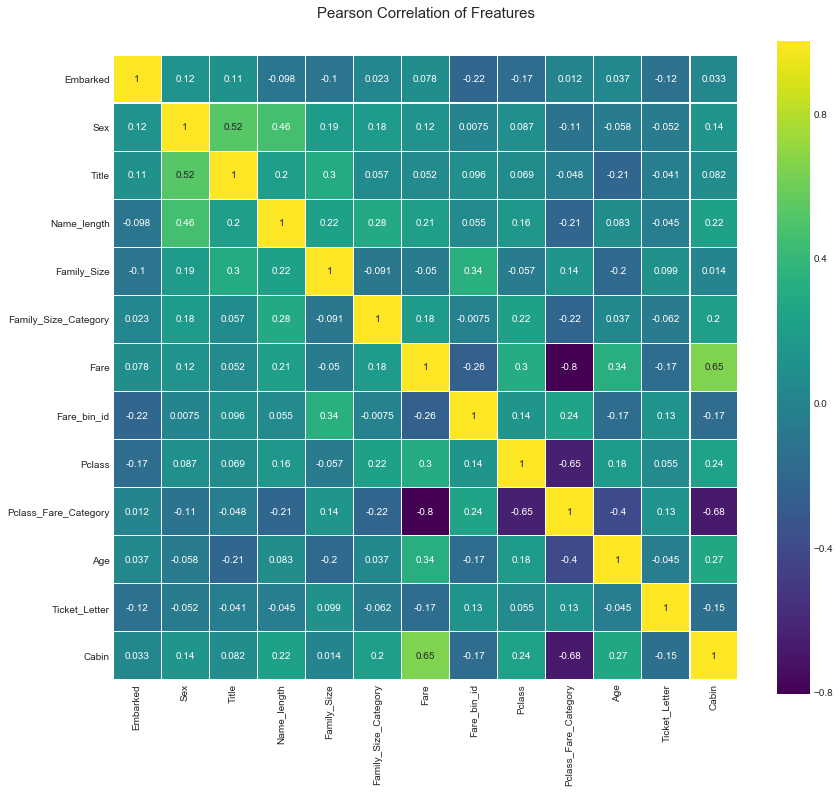

In [64]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Freatures', y=1.05, size=15)
sns.heatmap(Correlation.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

## 5. 特征之间的数据分布图

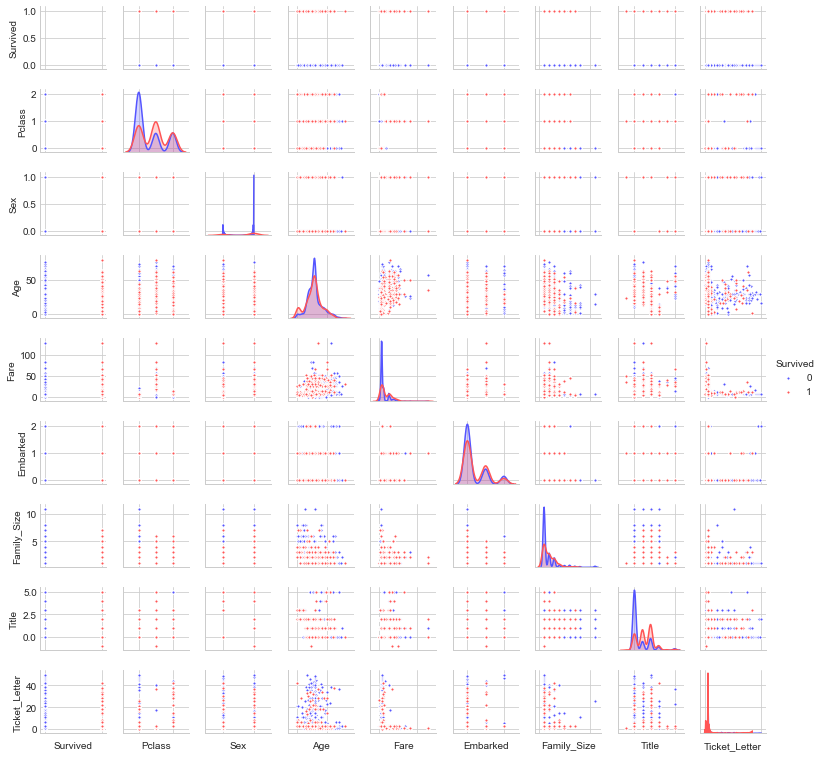

In [65]:
g = sns.pairplot(combined_train_test[[u'Survived', u'Pclass', u'Sex', u'Age', u'Fare', u'Embarked',
       u'Family_Size', u'Title', u'Ticket_Letter']], hue='Survived', palette='seismic', size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

## 7. 输入模型前的一些处理

### 7.1 一些数据的正则化

将Age和Fare正则化

In [66]:
scale_age_fare = preprocessing.StandardScaler().fit(combined_train_test[['Age','Fare','Name_length']])
combined_train_test[['Age','Fare','Name_length']] = scale_age_fare.transform(combined_train_test[['Age','Fare','Name_length']])

### 7.2 丢弃无用特征

特征工程中，我们从原始特征中提取了很多要融合到模型中的特征，但同时也要剔除那些原本用不到的或者非数值特征。

首先对数据进行备份，以便后期再次分析。

In [67]:
combined_data_backup = combined_train_test

In [68]:
combined_train_test.drop(['PassengerId', 'Embarked', 'Sex', 'Name', 'Title', 'Fare_bin_id', 'Pclass_Fare_Category', 
                          'Parch', 'SibSp', 'Family_Size_Category', 'Ticket'], axis=1, inplace=True)

### 7.3 将训练数据和测试数据分开

In [69]:
train_data = combined_train_test[:891]
test_data = combined_train_test[891:]

titanic_train_data_X = train_data.drop(['Survived'], axis=1)
titanic_train_data_Y = train_data['Survived']
titanic_test_data_X = test_data.drop(['Survived'], axis=1)

In [70]:
print(titanic_train_data_X.shape, titanic_train_data_Y.shape, titanic_test_data_X.shape)

(891, 33) (891,) (418, 33)


## 8. 模型融合及测试

下面将进行模型融合。

### 8.1 利用不同的模型来对特征进行筛选，选出较为重要的特征

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

def get_top_n_features(titanic_train_data_X, titanic_train_data_Y, top_n_features):

    # random forest
    rf_est = RandomForestClassifier(random_state=0)
    rf_param_grid = {'n_estimators': [500], 'min_samples_split': [2, 3], 'max_depth': [20]}
    rf_grid = model_selection.GridSearchCV(rf_est, rf_param_grid, n_jobs=25, cv=10, verbose=1)
    rf_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best RF Params:' + str(rf_grid.best_params_))
    print('Top N Features Best RF Score:' + str(rf_grid.best_score_))
    print('Top N Features RF Train Score:' + str(rf_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_rf = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': rf_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_rf = feature_imp_sorted_rf.head(top_n_features)['feature']
    print('Sample 10 Features from RF Classifier')
    print(str(features_top_n_rf[:10]))

    # AdaBoost
    ada_est =AdaBoostClassifier(random_state=0)
    ada_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1]}
    ada_grid = model_selection.GridSearchCV(ada_est, ada_param_grid, n_jobs=25, cv=10, verbose=1)
    ada_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best Ada Params:' + str(ada_grid.best_params_))
    print('Top N Features Best Ada Score:' + str(ada_grid.best_score_))
    print('Top N Features Ada Train Score:' + str(ada_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_ada = pd.DataFrame({'feature': list(titanic_train_data_X),
                                           'importance': ada_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_ada = feature_imp_sorted_ada.head(top_n_features)['feature']
    print('Sample 10 Feature from Ada Classifier:')
    print(str(features_top_n_ada[:10]))

    # ExtraTree
    et_est = ExtraTreesClassifier(random_state=0)
    et_param_grid = {'n_estimators': [500], 'min_samples_split': [3, 4], 'max_depth': [20]}
    et_grid = model_selection.GridSearchCV(et_est, et_param_grid, n_jobs=25, cv=10, verbose=1)
    et_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best ET Params:' + str(et_grid.best_params_))
    print('Top N Features Best ET Score:' + str(et_grid.best_score_))
    print('Top N Features ET Train Score:' + str(et_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_et = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': et_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_et = feature_imp_sorted_et.head(top_n_features)['feature']
    print('Sample 10 Features from ET Classifier:')
    print(str(features_top_n_et[:10]))

    # GradientBoosting
    gb_est =GradientBoostingClassifier(random_state=0)
    gb_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1], 'max_depth': [20]}
    gb_grid = model_selection.GridSearchCV(gb_est, gb_param_grid, n_jobs=25, cv=10, verbose=1)
    gb_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best GB Params:' + str(gb_grid.best_params_))
    print('Top N Features Best GB Score:' + str(gb_grid.best_score_))
    print('Top N Features GB Train Score:' + str(gb_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_gb = pd.DataFrame({'feature': list(titanic_train_data_X),
                                           'importance': gb_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_gb = feature_imp_sorted_gb.head(top_n_features)['feature']
    print('Sample 10 Feature from GB Classifier:')
    print(str(features_top_n_gb[:10]))

    # DecisionTree
    dt_est = DecisionTreeClassifier(random_state=0)
    dt_param_grid = {'min_samples_split': [2, 4], 'max_depth': [20]}
    dt_grid = model_selection.GridSearchCV(dt_est, dt_param_grid, n_jobs=25, cv=10, verbose=1)
    dt_grid.fit(titanic_train_data_X, titanic_train_data_Y)
    print('Top N Features Best DT Params:' + str(dt_grid.best_params_))
    print('Top N Features Best DT Score:' + str(dt_grid.best_score_))
    print('Top N Features DT Train Score:' + str(dt_grid.score(titanic_train_data_X, titanic_train_data_Y)))
    feature_imp_sorted_dt = pd.DataFrame({'feature': list(titanic_train_data_X),
                                          'importance': dt_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_dt = feature_imp_sorted_dt.head(top_n_features)['feature']
    print('Sample 10 Features from DT Classifier:')
    print(str(features_top_n_dt[:10]))

    # merge the three models
    features_top_n = pd.concat([features_top_n_rf, features_top_n_ada, features_top_n_et, features_top_n_gb, features_top_n_dt], 
                               ignore_index=True).drop_duplicates()

    features_importance = pd.concat([feature_imp_sorted_rf, feature_imp_sorted_ada, feature_imp_sorted_et, 
                                   feature_imp_sorted_gb, feature_imp_sorted_dt],ignore_index=True)

    return features_top_n , features_importance

### 8.2 根据筛选出的特征构建训练集和测试集

但如果在进行特征工程的过程中，产生了大量的特征，而特征与特征之间会存在一定的相关性。太多的特征一方面会影响模型训练的速度，另一方面也可能会使得模型过拟合。所以在特征太多的情况下，我们可以利用不同的模型对特征进行筛选，选取出我们想要的前n个特征。

In [72]:
feature_to_pick = 30
feature_top_n, feature_importance = get_top_n_features(titanic_train_data_X, titanic_train_data_Y, feature_to_pick)
titanic_train_data_X = pd.DataFrame(titanic_train_data_X[feature_top_n])
titanic_test_data_X = pd.DataFrame(titanic_test_data_X[feature_top_n])

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    7.8s remaining:    4.2s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    7.8s finished


Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best RF Score:0.8282828282828283
Top N Features RF Train Score:0.9809203142536476
Sample 10 Features from RF Classifier
16      Name_length
0               Age
2              Fare
10          Title_0
7             Sex_0
8             Sex_1
28      Family_Size
3            Pclass
32    Ticket_Letter
12          Title_2
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    7.6s remaining:    4.1s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    7.6s finished


Top N Features Best Ada Params:{'learning_rate': 0.01, 'n_estimators': 500}
Top N Features Best Ada Score:0.8159371492704826
Top N Features Ada Train Score:0.8204264870931538
Sample 10 Feature from Ada Classifier:
10                   Title_0
2                       Fare
28               Family_Size
7                      Sex_0
3                     Pclass
29    Family_Size_Category_0
1                      Cabin
8                      Sex_1
16               Name_length
0                        Age
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    7.3s remaining:    3.9s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    7.4s finished


Top N Features Best ET Params:{'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 500}
Top N Features Best ET Score:0.8271604938271605
Top N Features ET Train Score:0.9730639730639731
Sample 10 Features from ET Classifier:
10          Title_0
8             Sex_1
7             Sex_0
16      Name_length
0               Age
2              Fare
1             Cabin
32    Ticket_Letter
11          Title_1
12          Title_2
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:   26.4s remaining:   14.2s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:   27.2s finished


Top N Features Best GB Params:{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}
Top N Features Best GB Score:0.7811447811447811
Top N Features GB Train Score:0.9966329966329966
Sample 10 Feature from GB Classifier:
2              Fare
0               Age
16      Name_length
32    Ticket_Letter
10          Title_0
24         Pclass_2
28      Family_Size
18           Fare_1
15          Title_5
3            Pclass
Name: feature, dtype: object
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Top N Features Best DT Params:{'max_depth': 20, 'min_samples_split': 4}
Top N Features Best DT Score:0.7822671156004489
Top N Features DT Train Score:0.9629629629629629
Sample 10 Features from DT Classifier:
10                   Title_0
0                        Age
2                       Fare
16               Name_length
28               Family_Size
15                   Title_5
27                  Pclass_5
3                     Pclass
32             Ticket_Letter
31    Family_Si

[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    0.2s finished


用视图可视化不同算法筛选的特征排序

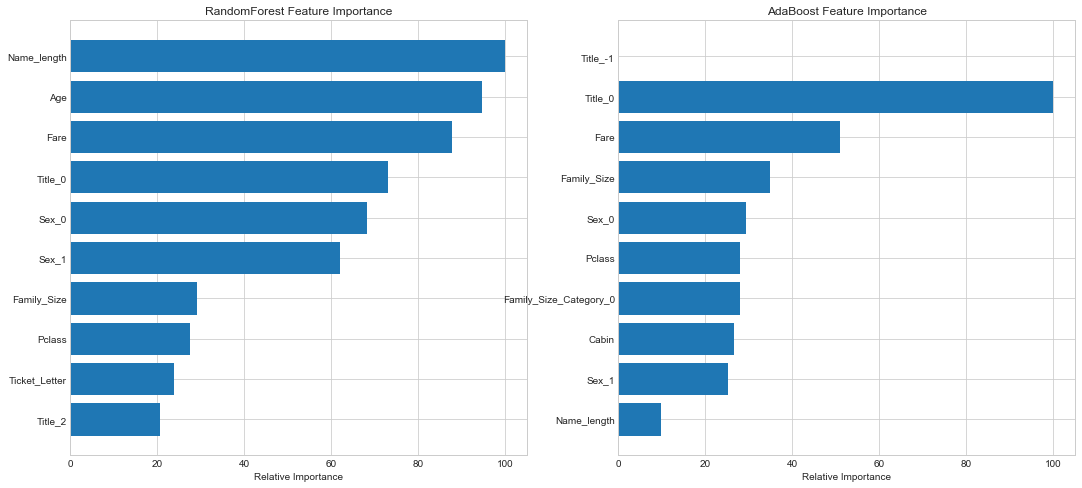

In [73]:
rf_feature_imp = feature_importance[:10]
Ada_feature_imp = feature_importance[32:32+10].reset_index(drop=True)

# make importances relative to max importance
rf_feature_importance = 100.0 * (rf_feature_imp['importance'] / rf_feature_imp['importance'].max())
Ada_feature_importance = 100.0 * (Ada_feature_imp['importance'] / Ada_feature_imp['importance'].max())

# Get the indexes of all features over the importance threshold
rf_important_idx = np.where(rf_feature_importance)[0]
Ada_important_idx = np.where(Ada_feature_importance)[0]

pos = np.arange(rf_important_idx.shape[0]) + .5

plt.figure(1, figsize=(18, 8))

plt.subplot(121)
plt.barh(pos, rf_feature_importance[rf_important_idx][::-1])
# pos为坐标，之后为数据，倒序排列
plt.yticks(pos, rf_feature_imp['feature'][::-1])
# 添加纵坐标标签
plt.xlabel('Relative Importance')
plt.title('RandomForest Feature Importance')

plt.subplot(122)
plt.barh(pos, Ada_feature_importance[Ada_important_idx][::-1])
plt.yticks(pos, Ada_feature_imp['feature'][::-1])
plt.xlabel('Relative Importance')
plt.title('AdaBoost Feature Importance')

plt.show()

### 8.3 模型融合

常见模型融合方法有：Bagging、Boosting、Stacking、Blending。

#### 8.3.1 Bagging

Bagging 将多个模型，也就是多个基学习器的预测结果进行简单的加权平均或者投票。它的好处是可以并行地训练基学习器。Random Forest就用到了Bagging的思想。

#### 8.3.2 Boosting

Boosting的每个基学习器是在上一个基学习器学习的基础上，对上一个基学习器的错误进行弥补。

#### 8.3.3 Stacking

Stacking是用新的次学习器去学习如何组合上一层的基学习器。如果把 Bagging 看作是多个基分类器的线性组合，那么Stacking就是多个基分类器的非线性组合。Stacking可以将学习器一层一层地堆砌起来，形成一个网状的结构。

相比来说Stacking的融合框架相对前面的二者来说在精度上确实有一定的提升，所以在下面的模型融合上，我们也使用Stacking方法。

#### 8.3.4 Blending

Blending 和 Stacking 很相似，但同时它可以防止信息泄露。

## 9. Stacking框架融合

这里使用了两层的模型融合，Level 1使用了：RandomForest、AdaBoost、ExtraTrees、GBDT、DecisionTree、KNN、SVM ，一共7个模型，Level 2使用了XGBoost使用第一层预测的结果作为特征对最终的结果进行预测。

### 9.1 Level 1

Stacking框架是堆叠使用基础分类器的预测作为二级模型的训练输入。然而，我们不能简单地在全部训练数据上训练基本模型，产生预测，输出用于第二层的训练。如果我们在Train Data上训练，然后在Train Data上预测，就会造成标签。为了避免标签，我们需要对每个基学习器使用K-fold，将K个模型对Valid Set的预测结果拼起来，作为下一层学习器的输入。

建立输出fold预测方法

In [74]:
from sklearn.model_selection import KFold

ntrain = titanic_train_data_X.shape[0] # 训练集数据的条数
ntest = titanic_test_data_X.shape[0] # 测试集数据的条数
SEED = 0 
NFOLDS = 7 # 设置folds
kf = KFold(n_splits=NFOLDS, random_state=SEED, shuffle=False)
# n_splits: 划分为NFOLDS等份，shuffle: 每次划分时，是否进行洗牌 random_state: 随机种子数

def get_out_fold(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        # kf.split: 将数据集划分为训练集和测试集
        # enumerate: 返回索引及对应的值
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.fit(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)
    # reshape(-1,1): -1:不知道行数有多少 1:将数据变为一列
    # example: reshape(2,-1): 将数据变为两行

构建不同的基学习器，这里我们使用了RandomForest、AdaBoost、ExtraTrees、GBDT、DecisionTree、KNN、SVM 七个基学习器

In [75]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

rf = RandomForestClassifier(n_estimators=500, warm_start=True, max_features='sqrt', max_depth=6,
                            min_samples_split=3, min_samples_leaf=2, n_jobs=-1, verbose=0)

ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)

et = ExtraTreesClassifier(n_estimators=500, n_jobs=-1, max_depth=8, min_samples_leaf=2, verbose=0)

gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.008, min_samples_split=3, min_samples_leaf=2, max_depth=5, verbose=0)

dt = DecisionTreeClassifier(max_depth=8)

knn = KNeighborsClassifier(n_neighbors=2)

svm = SVC(kernel='linear', C=0.025)

将pandas转换为arrays

In [76]:
# Create Numpy array of train, test and target(Survived) dataframes to feed into our models
x_train = titanic_train_data_X.values # Create an array of the train data
x_test = titanic_test_data_X.values # Create an array of the test data
y_train = titanic_train_data_Y.values

In [77]:
# Create our OOF train and test predictions. These base results will be uesd as new features.
rf_oof_train, rf_oof_test = get_out_fold(rf, x_train, y_train, x_test) # RandomForest
ada_oof_train, ada_oof_test = get_out_fold(ada, x_train, y_train, x_test) # AdaBoost
et_oof_train, et_oof_test = get_out_fold(et, x_train, y_train, x_test) # ExtraTrees
gb_oof_train, gb_oof_test = get_out_fold(gb, x_train, y_train, x_test) # GradientBoost
dt_oof_train, dt_oof_test = get_out_fold(dt, x_train, y_train, x_test) # DecisionTree
knn_oof_train, knn_oof_test = get_out_fold(knn, x_train, y_train, x_test) # KNeighbors
svm_oof_train, svm_oof_test = get_out_fold(svm, x_train, y_train, x_test) # SupportVector

print('Training is complete')

Training is complete


### 9.2 预测并生成提交文件

#### 9.2.1 Level 2

使用XGBoost，使用第一层预测的结果作为特征对最终的结果进行预测。

In [78]:
x_train = np.concatenate((rf_oof_train, ada_oof_train, et_oof_train, gb_oof_train, dt_oof_train, knn_oof_train, svm_oof_train), axis=1)
# np.concatenate: 将多个数组沿axis方向拼接在一起，这些数组必须拥有相同的形状。
x_test = np.concatenate((rf_oof_test, ada_oof_test, et_oof_test, gb_oof_test, dt_oof_test, knn_oof_test, svm_oof_test), axis=1)

In [79]:
from xgboost import XGBClassifier

gbm = XGBClassifier(n_estimators=2000, max_depth=4, min_child_weight=2, gamma=0.9, subsample=0.8, 
                    colsample_bytree=0.8, objective='binary:logistic', nthread=-1, scale_pos_weight=1).fit(x_train, y_train)

predictions = gbm.predict(x_test)

/Users/liyongda/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 10. 验证：学习曲线

在对数据不断地进行特征工程，产生的特征越来越多，用大量的特征对模型进行训练，会使我们的训练集拟合得越来越好，但同时也可能会逐渐丧失泛化能力，从而在测试数据上表现不佳，发生过拟合现象。

下图是在吴恩达老师的机器学习课程上给出的四种学习曲线

In [87]:
import requests
from ipywidgets import Image

Image(value=requests.get('https://img-blog.csdn.net/20171206093258359?watermark/2/text/aHR0cDovL2Jsb2cuY3Nkbi5uZXQvS29hbGFfVHJlZQ==/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70/gravity/SouthEast').content)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00d\x00d\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x02\…

上面红线代表test error（Cross-validation error），蓝线代表train error。这里我们也可以把错误率替换为准确率，那么相应曲线的走向就应该是上下颠倒的，（score = 1 - error）。

1. 左上角是最优情况，随着样本的增加，train error虽然有一定的增加吗，但是 test error却有很明显的降低；
2. 右上角是最差情况，train error很大，模型并没有从特征中学习到什么，导致test error非常大，模型几乎无法预测数据，需要去寻找数据本身和训练阶段的原因；
3. 左下角是high variance的情况，train error虽然较低，但是模型产生了过拟合，缺乏泛化能力，导致test error很高；
4. 右下角是high bias的情况，train error很高，这时需要去调整模型的参数，减小train error。

构建绘制学习曲线的函数

In [97]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid() # 绘制网格

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    # fill_between: 填充两函数间的区域
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [101]:
X = x_train
Y = y_train

# RandomForest
rf_parameters = {'n_jobs': -1, 'n_estimators': 500, 'warm_start': True, 'max_depth': 6, 'min_samples_leaf': 2, 
                 'max_features' : 'sqrt','verbose': 0}

# AdaBoost
ada_parameters = {'n_estimators':500, 'learning_rate':0.1}

# ExtraTrees
et_parameters = {'n_jobs': -1, 'n_estimators':500, 'max_depth': 8, 'min_samples_leaf': 2, 'verbose': 0}

# GradientBoosting
gb_parameters = {'n_estimators': 500, 'max_depth': 5, 'min_samples_leaf': 2, 'verbose': 0}

# DecisionTree
dt_parameters = {'max_depth':8}

# KNeighbors
knn_parameters = {'n_neighbors':2}

# SVM
svm_parameters = {'kernel':'linear', 'C':0.025}

# XGB
gbm_parameters = {'n_estimators': 2000, 'max_depth': 4, 'min_child_weight': 2, 'gamma':0.9, 'subsample':0.8, 
                  'colsample_bytree':0.8, 'objective': 'binary:logistic', 'nthread':-1, 'scale_pos_weight':1}

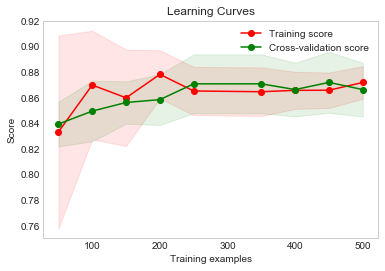

In [102]:
title = "Learning Curves"
plot_learning_curve(RandomForestClassifier(**rf_parameters), title, X, Y, cv=None,  n_jobs=4, train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500])
plt.show()

由以上结果可知，对于RadomForest模型，这里存在一定问题。

## 11. 总结

### 11.1 项目流程

1. 总览数据。head(),describe(),info()等方法对数据进行总览，明晰数据大致结构，对数据有一个全面的了解。
2. 处理缺失值。遇到数据中存在缺失值时，根据不同情况进行缺失值填充、剔除无用特征等操作。
3. 对数据关系进行分析。分析不同特征对Survived的影响程度，从而了解哪些特征对Survived影响较大，哪些特征对Survived影响较小。
4. 变量转换。分别应用定性与定量转换，将特征数据转换为机器学习模型可以识别的形式。
5. 特征工程。同时对训练集和测试集的不同特征进行处理，包括缺失值处理、特征融合、数值转换。然后分析不同特征间的相关性，了解哪里特征与哪些特征具有较高的相关性，哪些特征之间相关性较低。
6. 数据输入模型前的处理。这一步骤进行的操作主要有数据的正则化、剔除无用特征、训练数据测试数据的分离等。
7. 模型融合及测试。首先通过不同的模型来筛选重要的特征，然后根据筛选出来的特征构建测试集和训练集，再进行模型融合，最后得出预测结果。

### 11.2 可改进的地方

* 特征工程：寻找更好的特征，删去影响较大的冗余特征
* 模型超参数调试：改进欠拟合或者过拟合的状态
* 改进模型框架：对于stacking框架的各层模型进行更好的选择